Matthieu SCHLIENGER

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/navires-2022-a-la-mano/ships.tgz


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!tar xzf /kaggle/input/navires-2022-a-la-mano/ships.tgz

# Lire les images

In [4]:
image_size = (32, 32)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/ships32",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/ships32",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 51284 files belonging to 13 classes.
Using 41028 files for training.


2022-07-10 21:45:24.159110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:45:24.261067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:45:24.261793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:45:24.265264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 51284 files belonging to 13 classes.
Using 10256 files for validation.


# Visualiser les données

2022-07-10 21:45:28.320809: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


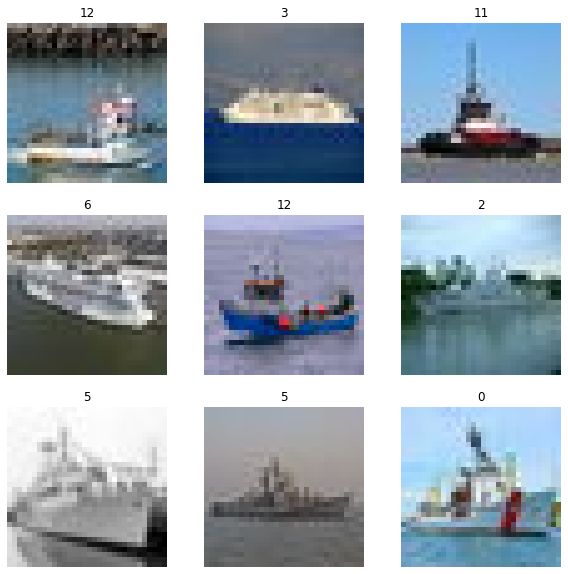

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Configuration de la data augmentation

#### Complétons notre dataset avec la data augmentation. Chaque image sera dupliquée et son clone subira une modification horizontale et uen légère rotation.

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

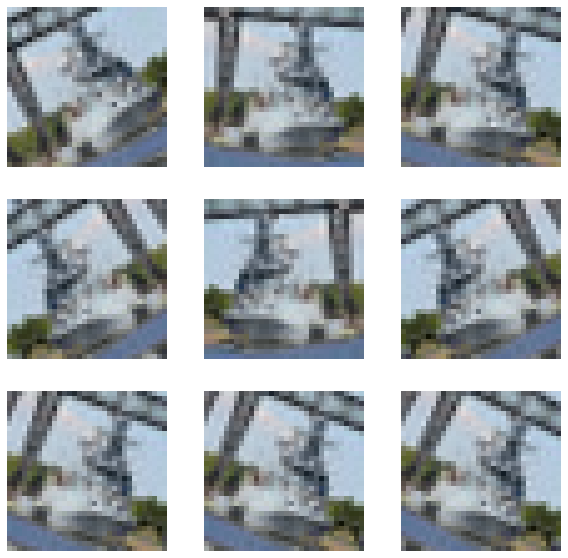

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Configuration du modèle

#### Le modèle est composée de 21 couches successives. Il est divisé en deux parties : une pour l'extraction de caractéristiques avec des couches convolutionnelles et de mise en commun qui extraient les caractéristiques des images, et un classificateur qui pondère ces caractéristiques et fait une prédiction.

In [9]:
from tensorflow.keras import layers, Model, optimizers

inputs = layers.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)

i=0
def block(inputs, filters, size, drop_out=None):
    global i
    i += 1
    x = layers.Conv2D(filters, size, padding='same', 
                        activation='swish',
                        name=f'conv{i}')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    if drop_out != None:
        x = layers.Dropout(drop_out)(x)
    return x

x = layers.Conv2D(32, (3, 3), padding='same', 
                       activation='swish',
                       input_shape=(32, 32, 3),
                       name ='stem_conv2d')(inputs)
x = layers.BatchNormalization(name='stem_bn')(x)
x = layers.Activation('swish', name='stem_activation')(x)

for i in range(5, 10):
    if i<9:
        x = block(x, np.power(2,i), (3,3), drop_out=0.2)
    else:
        x = block(x, np.power(2,i), (3,3))

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.Dropout(0.3, name="top_dropout")(x)
outputs = layers.Dense(13, activation="softmax", name="predictions")(x)

# Finally, we define the model by specifying the input and output
model = Model(inputs, outputs, name='Custom_model')
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  21


#### Pour améliorer notre modèle, on utilise des callbacks : 
#### * l'EarlyStopping permet d'arrêter le modèle lorsque celui-ci overfit
#### * le ModelCheckpoint va sauvegarder la meilleure version du modèle à chaque époque
#### * le ReduceLROnPlateau réduit le taux d'apprentissage lorsqu'une métrique a cessé de s'améliorer.

In [10]:
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=4, restore_best_weights=True)

# save best model indicating epoch
model_save = ModelCheckpoint('./weights/Custom_model_{epoch}.h5',
                             save_best_only=True, monitor='val_loss', verbose=1)
# Folder to save weights
if not os.path.exists('./weights'):
    os.makedirs('./weights', mode=0o770, exist_ok=True)
    
# reduce learning rate if val_loss does not decrease in 2 epochs, cooldown of 1 epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1)

In [11]:
print(model.summary())

Model: "Custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stem_conv2d (Conv2D)         (None, 32, 32, 32)        896       
_________________________________________________________________
stem_bn (BatchNormalization) (None, 32, 32, 32)        128       
_________________________________________________________________
stem_activation (Activation) (None, 32, 32, 32)        0         
_________________________________________________________________
conv6 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)       

# Entrainement de notre modèle

#### Nous allons lancer l'entrainement de notre modèle avec 30 époques. Passé 20 époques, le modèle overfit.

In [12]:
epochs = 30

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
hist = model.fit(
    train_ds, epochs=epochs, callbacks=[model_save, reduce_lr, early_stopping], validation_data=val_ds,
)

Epoch 1/30


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-07-10 21:45:32.139143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1283/1283 [==============================] - 19s 9ms/step - loss: 1.6440 - accuracy: 0.4554 - val_loss: 1.5807 - val_accuracy: 0.4777

Epoch 00001: val_loss improved from inf to 1.58072, saving model to ./weights/Custom_model_1.h5
Epoch 2/30
1283/1283 [==============================] - 12s 9ms/step - loss: 1.2002 - accuracy: 0.5940 - val_loss: 1.1317 - val_accuracy: 0.6144

Epoch 00002: val_loss improved from 1.58072 to 1.13168, saving model to ./weights/Custom_model_2.h5
Epoch 3/30
1283/1283 [==============================] - 12s 9ms/step - loss: 1.0685 - accuracy: 0.6356 - val_loss: 1.1316 - val_accuracy: 0.6172

Epoch 00003: val_loss improved from 1.13168 to 1.13160, saving model to ./weights/Custom_model_3.h5
Epoch 4/30
1283/1283 [==============================] - 12s 9ms/step - loss: 0.9829 - accuracy: 0.6632 - val_loss: 0.9923 - val_accuracy: 0.6701

Epoch 00004: val_loss improved from 1.13160 to 0.99225, saving model to ./weights/Custom_model_4.h5
Epoch 5/30
1283/1283 [=========

# Analyse du modèle

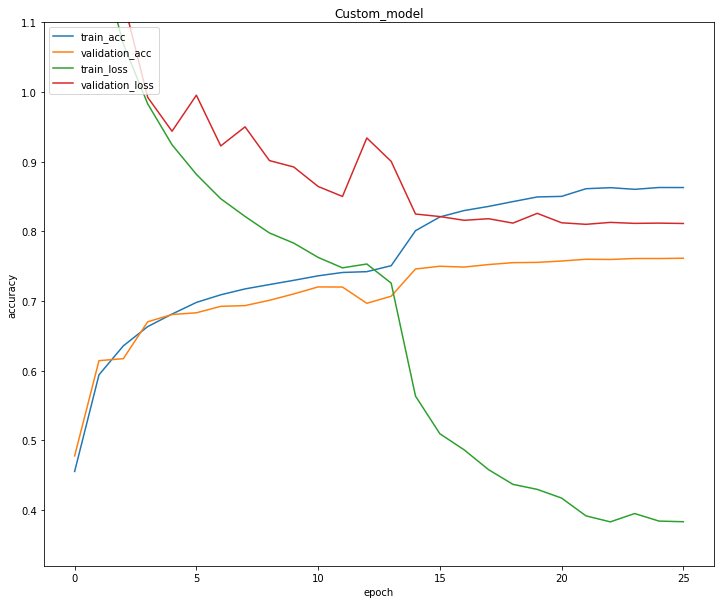

In [13]:
import matplotlib.pyplot as plt

def plot_hist(hist, name):
        """Plots training chart"""
        plt.figure(figsize=[12, 10])
        plt.plot(hist.history["accuracy"])
        plt.plot(hist.history["val_accuracy"])
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
        plt.title(f"{name}")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.ylim(top=1.1)
        plt.legend(["train_acc", "validation_acc", "train_loss", "validation_loss"], loc="upper left")
        plt.savefig(f'{name}_chart.png')
        plt.show()

plot_hist(hist, name='Custom_model')

# Résultat à soumettre

In [14]:
X_test = np.load('/kaggle/working/ships_competition.npz', allow_pickle=True)['X']
#X_test = X_test.astype('float32') / 255

In [15]:
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="Id")

In [16]:
!head submission.csv

Id,Category
0,5
1,5
2,7
3,11
4,12
5,5
6,5
7,5
8,7


In [17]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

In [18]:
!rm -rf ships32/